In [1]:
import os
import urllib3
import json
import re
import numpy as np
import matplotlib.image as mp
import pdal
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, mapping

In [2]:
MINX, MINY, MAXX, MAXY = [-93.759055, 41.925015, -93.766155, 41.935015]
polygon = Polygon(((MINX, MINY), (MINX, MAXY), (MAXX, MAXY), (MAXX, MINY), (MINX, MINY)))

In [3]:
class UsgsLidar:
    
    def __init__(self, path = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/", pipeline_json_path: str="../pipeline.json") -> None:
            
        self.path = path
        self.txt = self.read_txt("../data/filenames.txt")
        self.a = self.read_json("../pipeline.json")
        self.metadata = self.read_csv("../data/metadata.csv")
    
    def read_json(self, json_path):
        try:
            with open(json_path) as js:
                json_obj = json.load(js)
            return json_obj

        except FileNotFoundError:
            print('File not found.')
        
    def fetch_polygon_boundaries(self, polygon: Polygon):
        polygon_df = gpd.GeoDataFrame([polygon], columns=['geometry'])

        polygon_df.set_crs(epsg=4326, inplace=True)
        polygon_df['geometry'] = polygon_df['geometry'].to_crs(epsg=3857)
        minx, miny, maxx, maxy = polygon_df['geometry'][0].bounds

        polygon_input = 'POLYGON(('
        xcords, ycords = polygon_df['geometry'][0].exterior.coords.xy
        for x, y in zip(list(xcords), list(ycords)):
            polygon_input += f'{x} {y}, '
        polygon_input = polygon_input[:-2]
        polygon_input += '))'

        return f"({[minx, maxx]},{[miny,maxy]})", polygon_input
    
    def read_csv(self, csv_path, missing_values=["n/a", "na", "undefined"]):
        try:
            df = pd.read_csv(csv_path, na_values=missing_values)
            return df

        except FileNotFoundError:
            print('File not found.')
            
    def fetch_pipeline (self, region: str, polygon: Polygon):
        url = f"{self.path}{region}/ept.json"
        boundary, poly = self.fetch_polygon_boundaries(polygon)
        
        self.a['pipeline'][0]['filename']= f"{self.path}{region}/ept.json"
        self.a['pipeline'][0]['polygon'] = poly
        self.a['pipeline'][0]['bounds'] = boundary
        pipeline = pdal.Pipeline(json.dumps(self.a))
        
        return pipeline
    
    def execute_pipeline(self, polygon: Polygon, epsg=4326, region: str = "IA_FullState"):
        
        pipeline = self.fetch_pipeline(region, polygon)

        try:
            pipeline.execute()
            return pipeline
        except RuntimeError as e:
            print('Pipeline execution failed')
            print(e)
    
    
    def create_gpd_df(self, epsg, pipe):
        try:
            cloud = []
            elevations =[]
            geometry=[]
            for row in pipe.arrays[0]:
                lst = row.tolist()[-3:]
                cloud.append(lst)
                elevations.append(lst[2])
                point = Point(lst[0], lst[1])
                geometry.append(point)
            gpd_df = gpd.GeoDataFrame(columns=["elevation", "geometry"])
            gpd_df['elevation'] = elevations
            gpd_df['geometry'] = geometry
            gpd_df = gpd_df.set_geometry("geometry")
            gpd_df.set_crs(epsg = epsg, inplace=True)
            return gpd_df
        except RuntimeError as e:
            print(e)

    def fetch_region_data(self, polygon: Polygon, epsg=4326):
        pipeline = self.execute_pipeline(polygon, epsg)
        return self.create_gpd_df(epsg, pipeline)
    
    def read_txt(self, txt_path) -> list:
        try:
            with open(txt_path, "r") as f:
                text_file = f.read().splitlines()
            
            return text_file

        except Exception as e:
            print(e)
            
    def fetch_name_and_year(self, location: str) -> tuple:
        
        location = location.replace('/', '')
        regex = '20[0-9][0-9]+'
        match = re.search(regex, location)
        if(match):
          return (location[:match.start() - 1], location[match.start():match.end()])
        else:
          return (location, None)
    
   
    def fetch_metadata(self):
    
        metadata = pd.DataFrame(columns=['filename', 'region',
                          'year', 'xmin', 'xmax', 'ymin', 'ymax', 'points'])

        index = 0
        for lists in self.txt:
          r = urllib3.PoolManager().request('GET', self.path + lists + "ept.json")
          if r.status == 200:
            j = json.loads(r.data)
            region, year = self.fetch_name_and_year(lists)

            metadata = metadata.append({
                'filename': lists.replace('/', ''),
                'region': region,
                'year': year,
                'xmin': j['bounds'][0],
                'xmax': j['bounds'][3],
                'ymin': j['bounds'][1],
                'ymax': j['bounds'][4],
                'points': j['points']}, ignore_index=True)

            metadata.to_csv("../data/metadata.csv")
        
        return(metadata)
    
    
    def fetch_regions(self, polygon: Polygon, epsg=4326) -> list:
    
        polygon_df = gpd.GeoDataFrame([polygon], columns=['geometry'])

        polygon_df.set_crs(epsg, inplace=True)
        polygon_df['geometry'] = polygon_df['geometry'].to_crs(epsg=3857)
        minx, miny, maxx, maxy = polygon_df['geometry'][0].bounds

        cond_xmin = self.metadata.xmin <= minx
        cond_xmax = self.metadata.xmax >= maxx
        cond_ymin = self.metadata.ymin <= miny
        cond_ymax = self.metadata.ymax >= maxy


        df = self.metadata[cond_xmin & cond_xmax & cond_ymin & cond_ymax]
        sort_df = df.sort_values(by=['year'])
        regions = sort_df['filename'].to_list()
        if(len(df)==0):
            print("polygon is not located")
        
        return regions   
    
    def fetch_data(self, polygon: Polygon, region="IA_FullState") -> dict:
        regions = self.fetch_regions(polygon)

        region_dicto = {}
        for i in regions:
            if i==region:
                year = (self.metadata[self.metadata.filename == i].year.values[0])
                year = str(year)
                
                if(year=="nan"):
                    year = "Year: not_specified"
                
                region_df = self.fetch_region_data(polygon)
            
                if region_df.empty == False:
                    region_dicto[year] = region_df

        return(region_dicto)
    
    def plot_terrain(self, gdf: gpd.GeoDataFrame, fig_size: tuple=(12, 10), size: float=0.01):
       
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax = plt.axes(projection='3d')
        ax.scatter(gdf.geometry.x, gdf.geometry.y, gdf.elevation, s=size)
        plt.show()

In [4]:
US = UsgsLidar()
shape, poly = US.fetch_polygon_boundaries(polygon)
print(poly)

POLYGON((-10437210.259858532 5149753.664381643, -10437210.259858532 5151249.971344454, -10438000.628243161 5151249.971344454, -10438000.628243161 5149753.664381643, -10437210.259858532 5149753.664381643))


In [5]:
US.fetch_regions(polygon)

['NE_Rainwater-2_2009',
 'SD_James_River_NRCS_J_2010',
 'SD_McCook_County_2012',
 'SD_Spink_County_2012',
 'USGS_LPC_NE_Hat_White_Cherry_UTM14_2016_LAS_2019',
 'USGS_LPC_FL_Lower_Choctawhatchee_2017_LAS_2019',
 'USGS_LPC_NE_NRCS_OrthoLidar_B2_2017_LAS_2019',
 'IA_FullState']

In [6]:
geo_df = US.fetch_data(polygon)
geo_df = geo_df["Year: not_specified"]

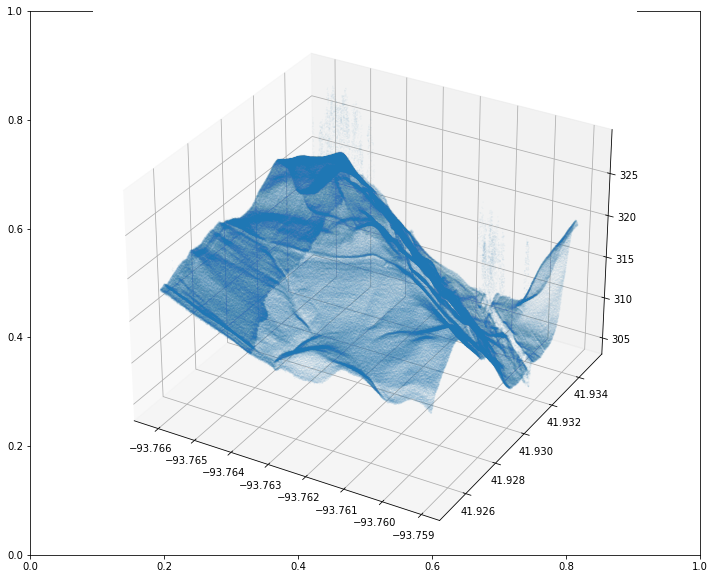

In [ ]:
US.plot_terrain(geo_df, size=0.001)

In [7]:
def save_heatmap(df, png_path, title) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    df.plot(column='elevation', ax=ax, legend=True, cmap="terrain")
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(png_path, dpi=120)
    plt.axis('off')
    plt.close()

In [8]:
def load_heatmap(png_path):
    fig, ax = plt.subplots(1, 1, figsize=(20, 18))
    img = mp.imread(png_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

In [9]:
save_heatmap(geo_df, "../data/heatmap2.png", "Polygon boundary map")

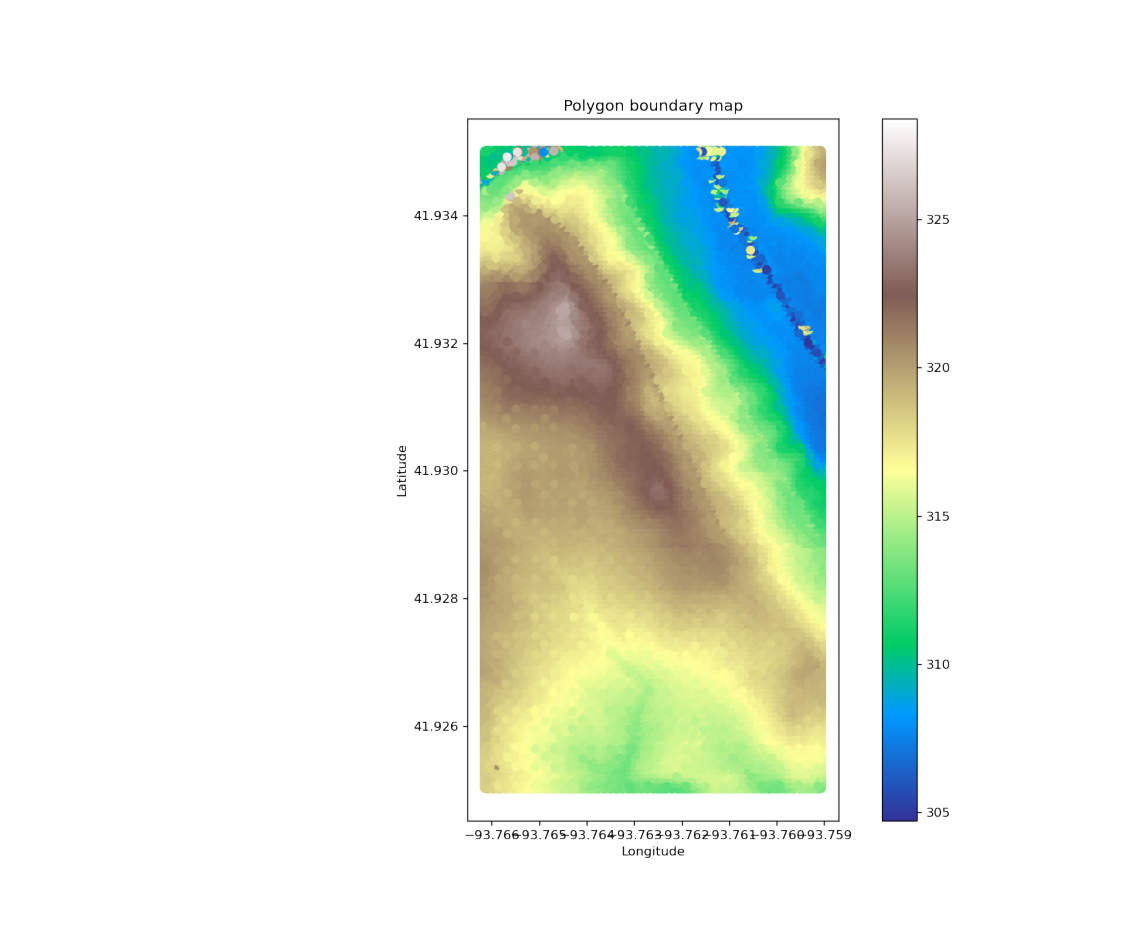

In [10]:
load_heatmap("../data/heatmap2.png")